## STOCHASTIC MODELING
MODULE 3 | LESSON 2


---


# **CALIBRATING INTEREST RATE MODELS** 


|  |  |
|:---|:---|
|**Reading Time** |  75 minutes |
|**Prior Knowledge** | Vasicek model, CIR model, Forward rates |
|**Keywords** | CIR, Calibration |


---

*In Lesson 1 of Module 3 of Stochastic Modeling, we looked at the different paths produced by Vasicek (1977) and CIR (1985) models. Since we used the same parameters (when we shouldn't) for generating interest rate paths, we observed a weird behavior in the comparison of both models. The answer to this behavior was the lack of parameter calibration. This is precisely what we will do now in Lesson 2.*

As usual, let's start with importing the necessary libraries:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## **1. Steps in the Calibration of Interest Rate Models**

We have been dealing with model calibration for a while now. In general the steps to follow are always the same:

- Get market data
- Build up your valuation function according to your model
- Error function (difference between model output and observed market prices)
- Optimization function (minimizing error function)

Throughout this notebook, we will guide you through these steps in the specific context of the CIR (1985) model. Note, however, that except for the specific bond valuation functions of CIR, the rest can be equally applied to Vasicek (1977) or any other short rate model. 


## **2. Get Bond Market Data**

The first task that we need to complete is to get Zero-Coupon-Bond (ZCB) market data. Now, remember that one of the most important features we need to take into account is risk-neutral valuation. For that reason, we have to look for market data on risk-free ZCBs.

The question of what exactly is a ZCB is not so easy to answer. As a generalization, for the U.S. we would use the Treasury Yield Curve (https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics), even though some of these bonds have an embedded coupon (i.e., they are not all exactly 'zero-coupon').

For the case of Europe, it is not so clear either. Historically, people have most commonly used Euribor (https://www.euribor-rates.eu/en/) or Eonia (currently nonexistent) rates. More recently, the ECB (European Central Bank) and other European agencies are working on providing a new short-term euro risk-free rate reference (https://www.ecb.europa.eu/paym/interest_rate_benchmarks/WG_euro_risk-free_rates/html/index.en.html).

In any case, for the purpose of this calibration we will use Euribor+Eonia rates on Sept, 30th, 2014. Remember we do this because this is the actual data for which we calibrated our options pricing models on EuroStoxx 50. Later on, we will incorporate the interest rate model calibration into an option pricing model for that date.

If we had consulted ECB on Sept. 30th, 2014, we would have obtained Euribor (risk-free) rates for different maturities (in days, divided by 360 to express it as a fraction of years):

In [3]:
mat_list = np.array((1, 7, 14, 30, 60, 90, 180, 270, 360)) / 360
rate_list = (
    np.array((-0.032, -0.013, -0.013, 0.007, 0.043, 0.083, 0.183, 0.251, 0.338)) / 100
)

## **3. Bond Pricing and Forward Rates in the CIR (1985) Model**

Next, we have to build up the valuation of bonds according to the Cox-Ingersoll-Ross model of 1985. 

The CIR model has the following general SDE:
$$
\
\begin{equation*}
  dr_t = k_r(\theta_r-r_t)dt + \sigma_r \sqrt{r_t} dz_t
\end{equation*}
$$
\
In this model, prices of ZCBs paying 1 monetary unit at T take the following form:
$$
\
\begin{equation*}
        B_0(T) = b_1(T) e^{-b_2(T)r_0}
\end{equation*}
$$
\
where
$$
\
\begin{equation*}
        b_1(T) = \left[ \frac{2\gamma e^{((k_r+\gamma)T/2)}}{ 2\gamma + (k_r +  \gamma)(e^{\gamma T}-1) } \right]^{\frac{2k_r\theta_r}{\sigma^2_r}}
\end{equation*}
$$
$$
\
\begin{equation*}
        b_2(T) = \frac{2(e^{\gamma T}-1)}{2\gamma + (k_r + \gamma)(e^{\gamma T}-1)}
\end{equation*}
$$
$$
\
\begin{equation*}
        \gamma = \sqrt{k^2_r + 2\sigma^2_r}
\end{equation*}
$$

### **3.1. Forward Rates and Capitalization Factors**

\
When we perform our calibration, the goal is going to select model parameters ($\kappa_r$, $\theta_r$, $\sigma_r$, $r_0$) so to minimize the differences between the rates produced by the model, and the rates observed in practice. In other words, minimize $\Delta f(0, t)$:

$$
\
\begin{equation*}
    \Delta f(0, t) \equiv f(0, t) - f^{CIR}(0, t; \kappa_r, \theta_r, \sigma_r, r_0)
\end{equation*}
$$
\
where $f(0,t)$ is the current market implied forward rate between $0$ and time $t$. Formally, the forward rate from any time $t$ to $T$ is defined as:
$$
\
\begin{equation*}
   f(t,T) \equiv -\frac{\partial B_t(T)}{\partial T}
\end{equation*}
$$
\
Now, using the previous formula and the expressions we know from the CIR (1985) model, we can define the forward rate between times $t$ and $T$ and a set of parameters $\alpha$ in the following way:
$$
\
\begin{equation*}
   f^{CIR}(t,T; \alpha) = \frac{\kappa_r \theta_r (e^{\gamma t}-1)}{2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1)} + r_0 \frac{4\gamma^2 e^{\gamma t}}{(2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1))^2}
\end{equation*}
$$
\
Of course, the fact we are considering forward rates makes a lot of sense; since we are going to be projecting things into the future, we would like to calibrate the model to the actual forward rates implied by the ZCB prices. 

Now, when using forward rates between two different times (e.g., $t$ and $T$), our bond valuation equation would slightly change in notation. You will realize that there are no major changes in the formula but, for the sake of completeness, we include them next (*Note: you can check the derivation of the different equations in, among others, Svoboda (2002), [which is available here](https://www.econbiz.de/Record/interest-rate-model-theory-with-reference-to-the-south-african-market-van-wijck-tjaart/10009442156):
$$
\
\begin{equation*}
        B_t(T) = a(t,T) e^{-b(t,T)\mathbf{E_0^Q}(r_t)}
\end{equation*}
$$
\
where
$$
\
\begin{equation*}
        a(t, T) = \left[ \frac{2\gamma e^{((k_r+\gamma)(T-t)/2)}}{ 2\gamma + (k_r +  \gamma)(e^{\gamma (T-t)}-1) } \right]^{\frac{2k_r\theta_r}{\sigma^2_r}}
\end{equation*}
$$
$$
\
\begin{equation*}
        b(t, T) = \frac{2(e^{\gamma (T-t)}-1)}{2\gamma + (k_r + \gamma)(e^{\gamma (T-t)}-1)}
\end{equation*}
$$
\
with 
$$
\
\begin{equation*}
    \mathbf{E_0^Q}(r_t) = \theta_r + e^{-\kappa_r t}(r_0- \theta_r)
\end{equation*}
$$
\
and, of course, still with $\gamma = \sqrt{k^2_r + 2\sigma^2_r}$.

\
Unfortunately, we do not typically get market quotes of the forward rates, which is what we need to properly execute our model calibration via minimizing $\Delta f(t,T)$ above for different $t$. Instead, we just have the yields (or rates) for different ZCBs and their maturities.

Luckily for us, there is a very simple way of going from bond yields to forward rates and vice versa (this, you should be familiar with even before the course). Suppose $Y(0, T)$ is the current bond yield (short rate) of a ZCB that pays 1 unit at maturity $T$:
$$
\
\begin{equation*}
    f(0, T) = Y(0, T) + \frac{\partial Y(0, T)}{\partial T}T
\end{equation*}
$$
\
Simultaneously, we know that the price of that bond today, given yield $Y(0, T)$ should solve the following equation:
$$
\
\begin{equation*}
    B_T(T) = B_0(T) e^{Y(0,T) T} \Leftrightarrow Y(0,T) = \frac{log B_T(T) - log B_0(T)}{T}
\end{equation*}
$$
\
and since we have normalized the face value of the bond at maturity to 1:
$$
\
\begin{equation*}
    Y(0,T) = -\frac{log B_0(T)}{T}
\end{equation*}
$$
\
Similarly, we can derive capitalization factors (the continuous yield of a unit ZCB) and equivalent annualized continuous rates. For example, capitalization factor, $f_s^{3m}$, for the 3 months Euribor rate, $Eur_{3m}$ would be:
$$
\
\begin{equation*}
    f_s^{3m} = 1 + 90/360 \times Eur_{3m}
\end{equation*}
$$
\
The equivalent annualized continuous rate, $f_c^{3m}$, is therefore defined as:
$$
\
\begin{equation*}
    f_c^{3m} = 360/90 \times log(f_s^{3m})
\end{equation*}
$$
\
which ensures the following relationship is satisfied:
$$
\
\begin{equation*}
    1 + 90/360 \times f_s^{3m} = e^{90/360 f^{3m}_c}
\end{equation*}
$$
\
So, now that we know all this, let's define the current short-term rate ($r_0$), the capitalization factors and the zero-forward rates implied by the Euribor rates observed in the market. (*Note that we are using 30/360 convention for the rates since this is the way Euribor--and most rates--are quoted*)

In [4]:
r0 = rate_list[0]
factors = 1 + mat_list * rate_list
zero_rates = 1 / mat_list * np.log(factors)

Let's plot our forward rates (from $t=0$) and the different maturities:

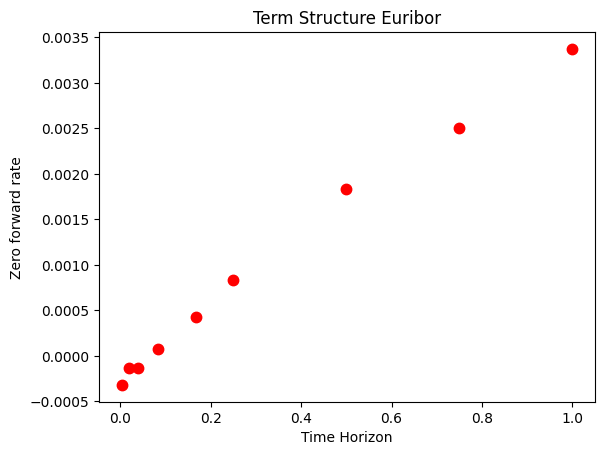

In [5]:
plt.plot(mat_list, zero_rates, "r.", markersize="15")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.show()


### **3.2. Interpolation of Market Rates**

Unfortunately, as we observe in the previous graph, there are a limited amount of rates quoted in the market. However, in order to calibrate the parameters of our model, we would like to have as many inputs (data points) as possible.

In order to do that, there is actually one common solution: interpolate the term structure of forward rates. This basically consists of fitting a function that can replicate the observed term structure and infer what would be the forward rate of a given maturity for which there is no market quote. 

There are several ways to interpolate a term structure (e.g., linear interpolation, fitting a model such as Nelson-Siegel using OLS, etc). Here, we will use a common way of interpolation, which is cubic spline interpolation.

We do not have much time to go over the spline interpolation method in depth, although it is likely that most students are familiar with this. The main idea you have to keep in mind is that it is a simple way to fill in the missing data in the term structure in a way that makes sense. For more details about interpolation, you can check this article (https://en.wikiversity.org/wiki/Cubic_Spline_Interpolation) and/or this video (https://www.youtube.com/watch?v=dxvmafuP9Wk).

Now, we are going to take advantage of the scipy package in Python and its built-in spline functions `splrep` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html#scipy.interpolate.splrep) and `splev` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splev.html#scipy.interpolate.splev). 

In the following code snippet, you can see how easily the interpolation is performed:

In [6]:
from scipy.interpolate import splev, splrep

In [7]:
bspline = splrep(mat_list, zero_rates, k=3)  # Cubic spline
mat_list_n = np.linspace(
    0.0, 1.0, 24
)  # Create 24 equally spaced maturities between 0 and 1
inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates

first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline
f = (
    inter_rates + first_der * mat_list_n
)  # Forward rate given interpolated ones and first derivative

Now, let's compare the output of our interpolation with the observed market quotes:

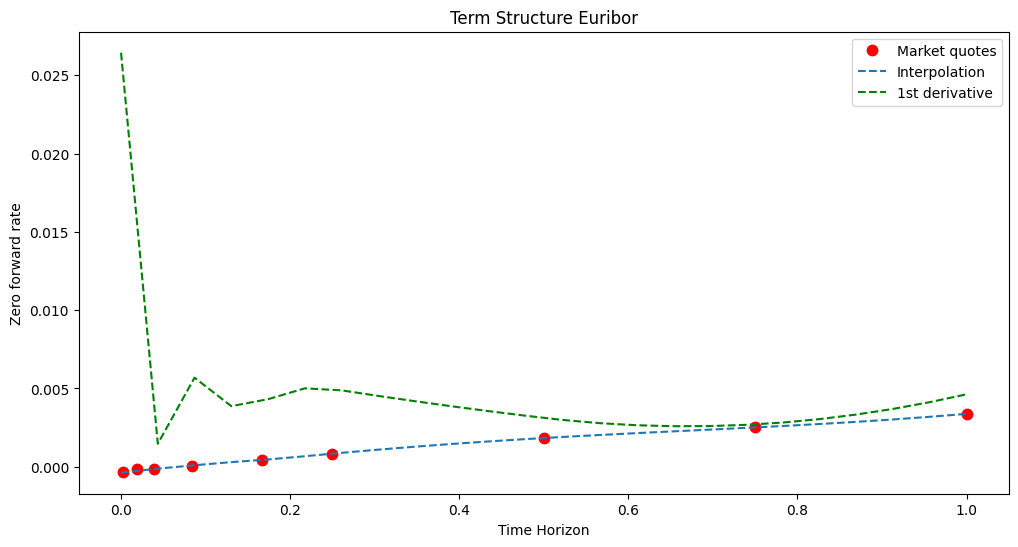

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(mat_list, zero_rates, "r.", markersize="15", label="Market quotes")
plt.plot(mat_list_n, inter_rates, "--", markersize="10", label="Interpolation")
plt.plot(mat_list_n, first_der, "g--", markersize="10", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

As you can see, we do not perfectly match the observed market data, but we are pretty close. In turn, we have many more data points that we can use to calibrate our interest rate model to observed (or, better said, interpolated from observed) market quotes.

Finally, before jumping to the pure calibration, let's define one last function. We will calibrate forward rates of the CIR (1985) model. Hence, let's define in Python the forward rate expression in the CIR model, $f^{CIR}(t,T; \alpha)$. Remember that we have already seen this expression before:
$$
\
\begin{equation*}
   f^{CIR}(t,T; \alpha) = \frac{\kappa_r \theta_r (e^{\gamma t}-1)}{2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1)} + r_0 \frac{4\gamma^2 e^{\gamma t}}{(2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1))^2}
\end{equation*}
$$


In [9]:
def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)-1)) ** 2)
    

    return s1 + s2


## **4. Error Function**

We have now completed the most novel and complex part of the calibration process, which is defining the specific function to calibrate for the model we are using. Next, we will define our error function, which basically is equivalent to other error functions we have defined before. In this case, we are using Mean Squared Error (MSE). This is, given $\alpha$ equal to the set of parameters to calibrate:

$$
\
\begin{equation*}
  min \frac{1}{M} \sum_{m=0}^{M} \left( f(0,m\Delta t) - f^{CIR}(0,m\Delta t; \alpha) \right)^2
\end{equation*}
$$
\
with $M = T / \Delta t$, that is, the number of market data points between $0$ and $T$.

In [10]:
def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """

    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE


## **5. Optimization**

Finally, we just need to create our optimization function to minimize the difference between model and market rates, very much in the same spirit as we have done a few times before for other models:

In [11]:
from scipy.optimize import fmin

In [12]:
def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )

    return opt

## **6. Results**

Now, we are ready to perform the whole calibration process as usual. First, let's run our calibration function to obtain the parameters:

In [13]:
params = CIR_calibration()
params

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 270
         Function evaluations: 485


array([0.14684901, 0.10451054, 0.17519711])

Although we may have exceeded the maximum number of function evaluations we set, we obtain parameters that closely match market data:

- $\kappa_r = 0.146$
- $\theta_r = 0.105$
- $\sigma_r = 0.175$

\
Then, let's see graphically the results of our calibration given the previous parameters:<span style='color: transparent; font-size:1%'>All rights reserved WQU WorldQuant University QQQQ</span>

In [14]:
def plot_calibrated_frc(opt):
    """Plots market and calibrated forward rate curves."""
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [min(mat_list_n) - 0.05, max(mat_list_n) + 0.05, min(f) - 0.005, max(f) * 1.1]
    )
    plt.subplot(212)
    wi = 0.02
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            min(mat_list_n) - 0.05,
            max(mat_list_n) + 0.05,
            min(forward_rates - f) * 1.1,
            max(forward_rates - f) * 1.1,
        ]
    )
    plt.tight_layout()

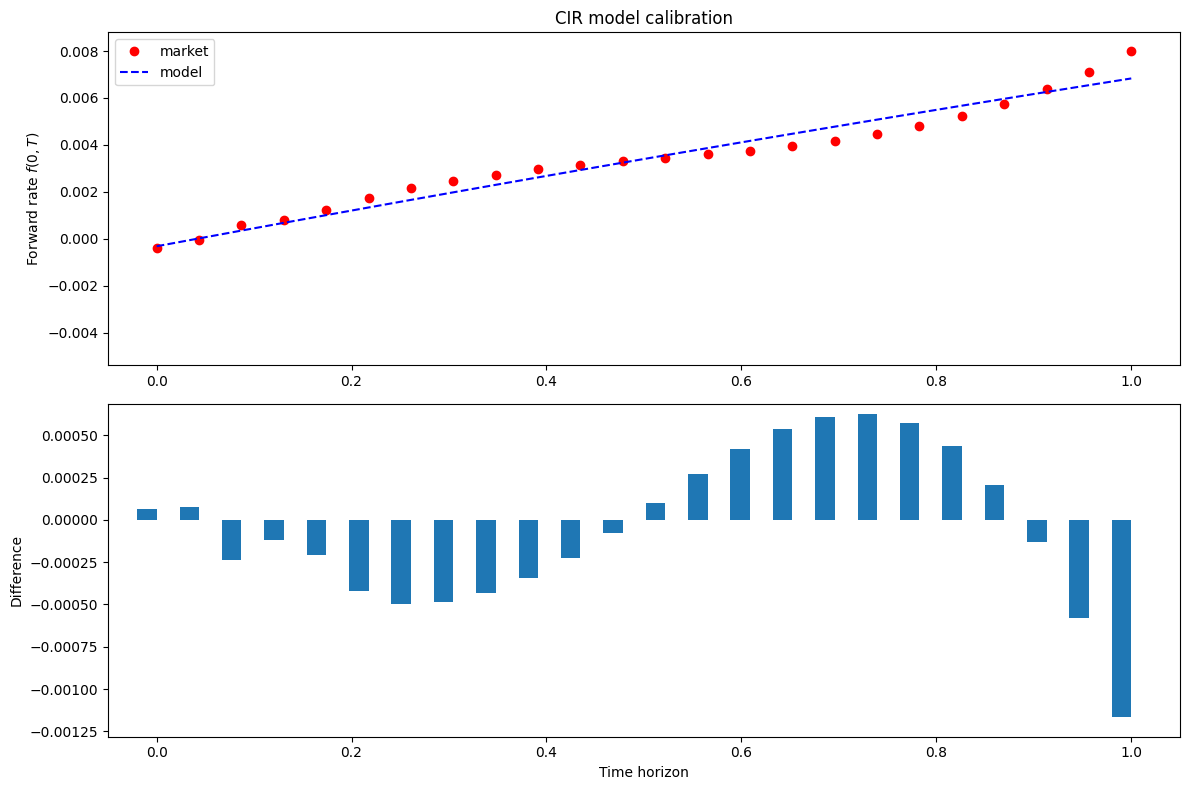

In [15]:
plot_calibrated_frc(params)


## **7. Conclusion**

In this lesson, we have performed a full calibration of the Cox-Ingersoll-Ross model of 1985. The model can be calibrated to several proxies for the risk-free rate. Here, we have calibrated the model to Euribor rates in Sept. 2014, as you would do if you had to use these rates to later price an option on an European index such as EuroStoxx50. This is precisely what we will do next: incorporate the calibration of interest rates to a complete option pricing model that takes into account stochastic rates and volatility, together with a jump diffusion. 

\
**References**

- Cox, John C., et al. "An Intertemporal General Equilibrium Model of Asset Prices." *Econometrica: Journal of the Econometric Society*, 1985, pp. 363-384.

- Svoboda, Simona. *An Investigation of Various Interest Rate Models and Their Calibration in the South African Market.* 2002. University of the Witwatersrand, Dissertation. https://www.econbiz.de/Record/interest-rate-model-theory-with-reference-to-the-south-african-market-van-wijck-tjaart/10009442156

---
Copyright 2025 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
